In [16]:
%reload_ext autoreload
%autoreload 2

# Imports

In [17]:
from kret_notebook import *  # NOTE import first
from kret_matplotlib.mpl_nb_imports import *
from kret_np_pd.np_pd_nb_imports import *
from kret_polars.polars_nb_imports import *
from kret_rosetta.rosetta_nb_imports import *
from kret_lgbm.lgbm_nb_imports import *
from kret_sklearn.sklearn_nb_imports import *
from kret_torch_utils.torch_nb_imports import *
from kret_lightning.lightning_nb_imports import *
from kret_tqdm.tqdm_nb_imports import *
from kret_type_hints.types_nb_imports import *
from kret_utils.utils_nb_imports import *

# from kret_wandb.wandb_nb_imports import *  # NOTE this is slow to import

# Load Models

In [ ]:
model_filename = "lgbm-medical-example.pkl"
load_and_clean = "load_and_clean.pkl"
scale_and_predict = "scale_and_predict.pkl"
save_folder = UKS_CONSTANTS.LGBM_MODEL_WEIGHT_DIR / "medical"

In [ ]:
pipeline_load_and_clean: PipelinePD = joblib.load(save_folder / load_and_clean)
pipeline_scale_ols: PipelinePD = joblib.load(save_folder / scale_and_predict)
model_loaded: LGBMRegressor = joblib.load(save_folder / model_filename)

In [ ]:
model_loaded

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# Load Data


In [20]:
df = pipeline_load_and_clean.fit_transform_df(UKS_CONSTANTS.DATA_DIR / "medical_cost.csv")

In [ ]:
features, target = UKS_NP_PD.pop_label_and_drop(df, label_col="charges", drop_cols=["Id"])
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.15, random_state=0)

In [22]:
x_train = pipeline_scale_ols.transform_df(x_train)
x_val = pipeline_scale_ols.transform_df(x_val)

In [23]:
y_hat_train_ols = x_train.pop("y_hat")
resid_train = y_train - y_hat_train_ols
y_hat_val_ols = x_val.pop("y_hat")
resid_val = y_val - y_hat_val_ols

# Make Predictions

In [25]:
y_pred_resid_loaded = model_loaded.predict(x_val)
y_hat_loaded = y_pred_resid_loaded + y_hat_val_ols

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [26]:
gs_loaded = GroupScatterUKS(y_val, y_hat_loaded)

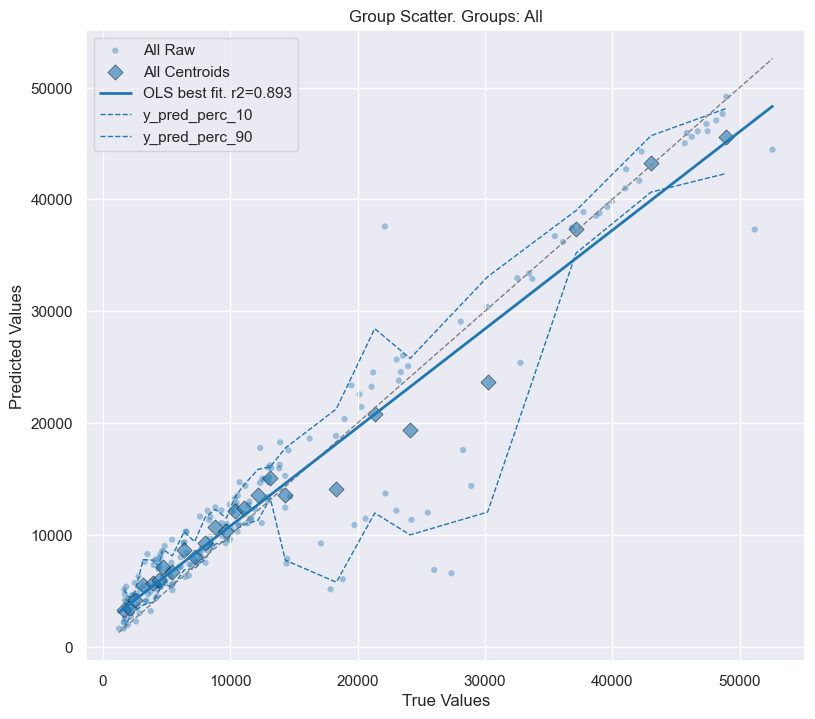

In [27]:
gs_loaded.plot(scatters=("raw", "centroids"), percentiles=(10, 90))